In [1]:
#  this is for showing image on jupyter notebook
from IPython.display import Image

### 참고자료
ref) https://www.youtube.com/watch?v=HMcx-zY8JSg

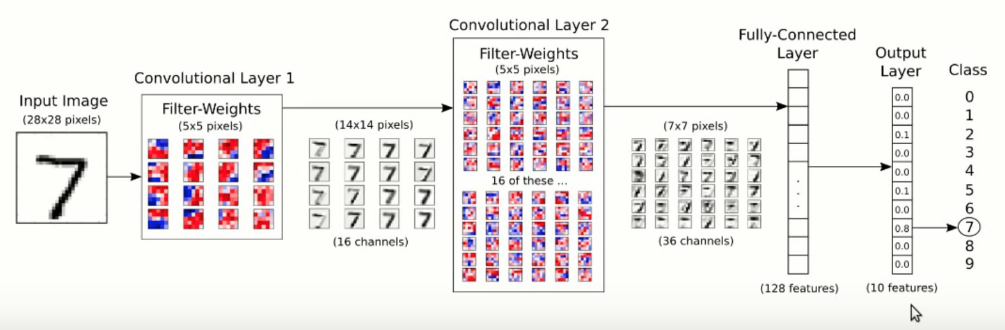

In [2]:
Image(filename="ref img/cnn mnist big pic.png", height = 300, width=900 )

#### above image show basic process. the channel numbers are different from my example, but i can get the basic concept.
<hr><hr><hr>

In [60]:
import sys

In [61]:
import tensorflow as tf

In [62]:
# use examples data which is provided by tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot = True ) 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [63]:
# helper func which return init weights
def init_weights(shape):
    init_random_dist = tf.random.truncated_normal(shape, stddev= 0.01)
    return tf.Variable(init_random_dist)

In [64]:
# helper fucn which return init bias
def init_bias(shape):
    init_bias = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias)

## conv2d
#### ref) https://www.tensorflow.org/api_docs/python/tf/nn/conv2d
#### this is data tensor    x = [batch, in_height, in_width, in_channels] 
#### this is filter      W = [filter_height, filter_width, in_channels, out_channels]

#### intuition of conv2d 
#### ref) https://stackoverflow.com/a/34698115/3151712

In [65]:
def conv2d(x,W):
#     x ----> [batch_size, height, width, num_channels]
#     W ----> [filter_height, filter_width, channels_in, channels_out ]
    
#     stride decides how far filter moves whenever filter moves 
#     padding = "SAME" will set padding zero
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

In [66]:
# helper func which return max pooling
def max_pooling_2by2(x):
#     x ----> [batch_size, height, width, channel]
 
#     max_pool size is 2 by 2
#     max_pool will be applied on one image and one channel , so ksize and stride will [1, * , *, 1] form 
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [67]:
# helper func which returns convolution layer
def convolution_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [68]:
# helper func which returns fully connected layer
def fully_connected_layer(input_layer, target_size):
    
#     input_layer would be right before layer 
#     input_layer will return shape. something like 3 * 6
#     index 1 will return num_of column
    input_size = int(input_layer.get_shape()[1])
    
#     product 2 * 3 matrix and 3 * 4 matrix will be 2 * 4 matrix
#     so we setting column size as target_size
    W = init_weights([input_size, target_size])
    
    b = init_bias([target_size])
    
    return tf.matmul(input_layer, W)+b

In [69]:
# placeholders

# batch size is unknown, so None
# mnist image size is 28 * 28 = 784
x = tf.placeholder(tf.float32,shape =[None, 784])

# we tried to guess 1 - 10 numbers
y_true = tf.placeholder(tf.float32, shape = [None, 10])

In [70]:
# if i use -1 in the shape, that means remainder which is decided after every others takes data
# 28 heights, 28 width, 1 channel
x_image = tf.reshape(x, shape=[-1,28,28,1])

In [71]:
# layer 1

# filter size is 5 by 5
# channel in is 1 (gray channel image)
# channel out is 32 (32 features)
convo_1 = convolution_layer(x_image,shape=[5,5,1,32])
maxpooling_1 = max_pooling_2by2(convo_1)

In [72]:
# layer 2

# filter size is 5 by 5
# channel in is 32 (decided by layer 1)
# channel out is 64 (64 features)
convo_2 = convolution_layer(input_x=maxpooling_1 , shape=[5,5,32,64])
maxpooling_2 = max_pooling_2by2(convo_2)

In [73]:
maxpooling_2.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(64)])

In [74]:
# layer 3
flat_maxpooling_2 = tf.reshape(maxpooling_2, shape=[-1, 7*7*64]) 
full_layer_one = tf.nn.relu(fully_connected_layer(flat_maxpooling_2, 1024))

In [75]:
# dropout 
# dropout is for reducing overfitting

dropout_rate = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, rate= dropout_rate)

In [76]:
# we need 10 classes (1-10)
y_pred = fully_connected_layer(full_one_dropout, 10)

#### ref) https://stackoverflow.com/a/34272341/3151712
#### tf.nn.softmax computes the forward propagation through a softmax layer. You use it during evaluation of the model when you compute the probabilities that the model outputs.

#### tf.nn.softmax_cross_entropy_with_logits computes the cost for a softmax layer. It is only used during training.

#### The logits are the unnormalized log probabilities output the model (the values output before the softmax normalization is applied to them).

In [77]:
# loss function

# comparing y_true and y_pred , and get the average of the values
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_pred ))

In [78]:
# optimizer

optimizer = tf.train.AdamOptimizer(learning_rate=0.02)
train = optimizer.minimize(cross_entropy)

In [79]:
init = tf.global_variables_initializer()

In [85]:
steps = 100

In [88]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(steps):
        
        x_batch, y_batch = mnist.train.next_batch(50)
        
        sess.run(train, feed_dict={x:x_batch, y_true:y_batch, dropout_rate:0.1})
        
        if i%10 == 0:
            print("{} steps right now".format(i))
            print("accuracy = ")
            
            num_matches = tf.equal(tf.arg_max(y_pred,1),tf.arg_max(y_true,1))
        
            accuracy = tf.reduce_mean(tf.cast(num_matches,tf.float32))
            
            acc , matches = sess.run([accuracy,num_matches], feed_dict={x:mnist.test.images, y_true:mnist.test.labels, dropout_rate:0})
        
            print(acc)
            print("\n")
            print(matches)

            
            print("\n")
        
        

0 steps right now
accuracy = 
0.101


[False False False ... False False False]


10 steps right now
accuracy = 
0.1086


[False False False ... False False False]


20 steps right now
accuracy = 
0.2708


[False False  True ... False False False]


30 steps right now
accuracy = 
0.3562


[False False  True ... False False  True]


40 steps right now
accuracy = 
0.5457


[ True  True  True ... False False False]


50 steps right now
accuracy = 
0.7087


[ True  True  True ... False  True  True]


60 steps right now
accuracy = 
0.7217


[ True  True  True ... False False  True]


70 steps right now
accuracy = 
0.7415


[ True  True  True ... False  True  True]


80 steps right now
accuracy = 
0.7712


[ True  True  True ... False  True  True]


90 steps right now
accuracy = 
0.7969


[ True  True  True ... False  True  True]


